In [1]:
import sys
sys.path.insert(0, '..')
#for local import of parent dict

import scanpy as sc
import pandas as pd
import numpy as np
import pathlib
import scipy
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from ggml.plot import plot_heatmap, hier_clustering, plot_emb, plot_ellipses
from ggml.generator import get_pointcloud
from tqdm import tqdm

import ot

4.002003675351168e-15


In [2]:
#move into package TODO

def get_cells_by_patients(adata_path,patient_col="donor_id",label_col="reported_diseases",subsample_patient_ratio=0.5,n_feats=None,max_cells = None,filter_genes=False,**kwargs):
    global adata
    adata = sc.read_h5ad(adata_path+".h5ad")  #adata_path+".h5ad")
    print(adata)

    string_class_labels = np.unique(adata.obs[label_col])

    if filter_genes:
        #detect low variable genes
        gene_var = np.var(adata.X.toarray(),axis=0)
        #filter
        thresh = np.mean(gene_var) #TODO make this not hardcoded and arbitrary
        adata = adata[:,gene_var >thresh]
        #adata.write(adata_path+"_filtered.h5ad")

    distributions = []
    distributions_class = []
    patient_labels = []
    disease_labels = []
    celltype_node_label = []

    if n_feats is not None:
        global pca
        pca = PCA(n_components=n_feats, svd_solver='auto')
        pca.fit(adata.X)
    unique_patients = np.unique(adata.obs[patient_col])
    unique_patients_subsampled = np.random.choice(unique_patients, size = int(len(unique_patients)*subsample_patient_ratio),replace=False)


    for patient in unique_patients_subsampled:
        
        
        patient_adata = adata[adata.obs[patient_col] == patient]

        disease_label = np.unique(patient_adata.obs[label_col].to_numpy())
        string_class_label = disease_label[0]
        print(disease_label)
        if len(disease_label) > 1:
            print("Warning, sample_ids refer to cells with multiple disease labels (likely caused by referencing by patients and having multiple samples from different zones)")

        '''
        unique,pos = np.unique(patient_adata.obs[label_col].to_numpy(),return_inverse=True) #Finds all unique elements and their positions
        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = counts.argmax()                      #Finds the positions of the maximum count
        string_class_label = unique[maxpos] #we take the label that occurs most often for this patient
        patient_adata = adata[adata.obs[label_col] == string_class_label ] # and only keep those (this is only relevant for myocardial infarction)
        '''

        if max_cells is not None and patient_adata.n_obs > max_cells:
            sc.pp.subsample(patient_adata,n_obs = max_cells) 

        #p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?

        #if n_feats == 50:
        #    p_arr = np.asarray(patient_adata.obsm["X_pca"],dtype="f")
        #else:
        p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?
        if n_feats is not None:
            p_arr = pca.transform(p_arr)

        distributions.append(p_arr)
        
        disease_labels.append(string_class_label)
        #distributions_class.append(np.where(string_class_labels==string_class_label)[0][0])
        patient_labels.append(patient)
        celltype_node_label.append(list(patient_adata.obs['cell_type']))
            
        #Cell level
    points = np.concatenate(distributions) #np.reshape(np.asarray(dists),(-1,2))
    print(distributions)
    point_labels = sum([[l] * len(D) for l,D in zip(disease_labels,distributions)],[]) #flattens list of lists
    print(point_labels)

    #return distributions, distributions_class, patient_labels, disease_labels, celltype_node_label
    return distributions, disease_labels, points, point_labels, celltype_node_label

    distributions, distributions_class, patient_labels, disease_labels, 

#distributions, distributions_labels, patient_labels = get_cells_by_patients(dataset_folder+dataset_name,patient_col="donor_id",label_col=label_col)
#print(distributions_labels)

def compute_OT(distributions,labels,precomputed_distances=None,ground_metric = None,w = None,legend=None,numThreads=32):
    D = np.zeros((len(distributions),len(distributions)))
    for i,distribution_i in enumerate(distributions):
        for j,distribution_j in enumerate(distributions):
            if i < j:
                if w is not None:
                    M = pairwise_mahalanobis_distance_npy(distribution_i,distribution_j,w)
                elif precomputed_distances is not None:
                    start_i = int(np.sum([len(dist) for dist in distributions[:i]]))
                    start_j = int(np.sum([len(dist) for dist in distributions[:j]]))
                    if precomputed_distances.ndim == 1:
                        precomputed_distances = scipy.spatial.distance.squareform(precomputed_distances)
                    M = np.asarray(precomputed_distances)[start_i:start_i+len(distribution_i),start_j:start_j+len(distribution_j)]

                D[i,j] = ot.emd2([],[],M,numThreads=numThreads)
                #TODO handle non mahalanobis distances
            else:
                D[i,j]=D[j,i]
    
    hardcoded_symbols = [i % 4 for i in range(len(distributions))]
    plot_emb(D,method='umap',colors=labels,symbols=hardcoded_symbols,legend=legend,title="UMAP",verbose=True,annotation=None,s=200)
    plot_emb(D,method='diffusion',colors=labels,symbols=hardcoded_symbols,legend=legend,title="DiffMap",verbose=True,annotation=None,s=200)

    hier_clustering(D,labels, ax=None,dist_name="W_θ")
    return D

from sklearn.metrics.pairwise import pairwise_distances

def pairwise_mahalanobis_distance_npy(X_i,X_j=None,w=None,numThreads=60):
    # W has shape dim x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 
    if X_j is None:
        if w is None or isinstance(w,str):
            return pairwise_distances(X_i,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
        else:
            if w.ndim == 2 and w.shape[0]==w.shape[1] and len(w)>2:
                print("predefined mahala")
                return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)    
            else:
                X_j = X_i
    #Transform poins of X_i,X_j according to W
    if w is None or isinstance(w,str):
        return scipy.spatial.distance.cdist(X_i,X_j,metric=w)
    #Assume w is cov matrix of mahalanobis distance
    elif w.ndim == 1:
        #assume cov=0, scale dims by diagonal
        w = np.diag(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)

        #proj_X_i = X_i * w[None,:]
        #proj_X_j = X_j * w[None,:]
    else: 
        w = np.transpose(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)
    
    print("projected shape")
    print(proj_X_i.shape)
    return np.linalg.norm(proj_X_i[:,np.newaxis,:]  -  proj_X_j[np.newaxis,:,:],axis=-1)  


In [3]:
metric_params = {}
times = {}

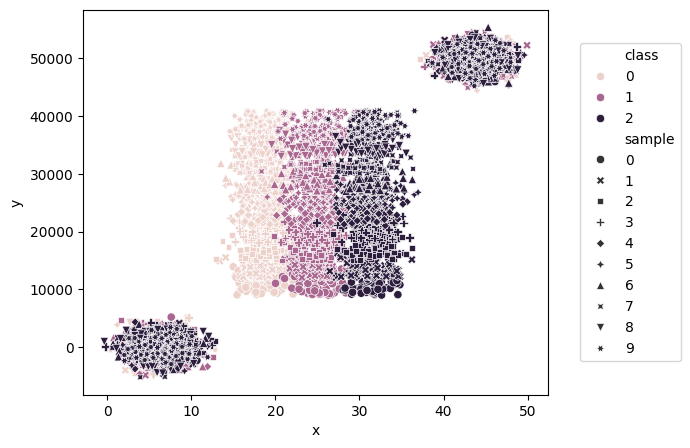

In [4]:
#Synth Data

n = 100
means = [5,10,15]
label =[0,1,2]
offsets = np.arange(0,30,3)+1.5

shared_means_x = [5, 35]
shared_means_y = [0, 50] 

#dims = 2 #TODO remove hardcoded


train_datasets = {
    "synth_2D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1000,noise_dims=1),
    #"synth_200D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=199)
    #"synth_KD": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=999)
}

datasets = {
    #"synth_2D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1000,noise_dims=1),
    #"synth_200D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=199)
}

In [ ]:
if True:
    #Load scRNA datasets
    dataset_folder = "/home/kuehn/ot_metric_learning/damin-ggml/data/datasets/"
    dataset_loading = {
        #"breastcancer_full":{"path":"b8b5be07-061b-4390-af0a-f9ced877a068","label_col":"reported_diseases","patient_col":"donor_id"},
        #"kidney_v2":{"path":"1c360b0b-eb2f-45a3-aba9-056026b39fa5","label_col":"disease","patient_col":"donor_id"},
        "myocard_infarct_full":{"path":"c1f6034b-7973-45e1-85e7-16933d0550bc","label_col":"patient_group","patient_col":"sample"}, #major_labls
    }

    n_threads = 20
    pca_c = None #50

    max_cells = 1000 #None 
    subsample_patient_ratio = 1.0


    for dataset_name,loading_info in dataset_loading.items():
        #Test
        data_dict = {}
        data_dict["distributions"],data_dict["distributions_labels"],data_dict["points"], data_dict["point_labels"], data_dict["distribution_modes"]= get_cells_by_patients(dataset_folder+loading_info["path"],loading_info["patient_col"],loading_info["label_col"],subsample_patient_ratio=subsample_patient_ratio,n_feats=pca_c,max_cells = max_cells,filter_genes=True)
        datasets[dataset_name] = data_dict

        #Train
        data_dict2 = {}
        data_dict2["distributions"],data_dict2["distributions_labels"],data_dict2["points"], data_dict2["point_labels"], data_dict2["distribution_modes"] = get_cells_by_patients(dataset_folder+loading_info["path"],loading_info["patient_col"],loading_info["label_col"],subsample_patient_ratio=0.5,n_feats=pca_c,max_cells = max_cells,filter_genes=True)
        train_datasets[dataset_name] = data_dict2


In [ ]:
from metric_learn import LMNN, LFDA, MLKR, NCA, ITML_Supervised
metrics = {
    "Euclidean": lambda _: "euclidean", # lambda dims:np.eye(dims),
    "Manhatten": lambda _ : "cityblock",
    "Jaccard": lambda _ : "jaccard",
    "Cosine": lambda _ : "cosine",
    #"LMNN": lambda data:LMNN(n_neighbors=30,random_state=42,learn_rate=1e-6,max_iter=100).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    #"LFDA": lambda data:LFDA(k=30).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    "NCA" : lambda data: NCA(random_state=42).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    #"ITML": lambda data: ITML_Supervised(random_state=42).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    "GGML_L2": None,
}
#Load params for learned metric
metric_params_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters"

#If pipeline should only be rerun for some datasets
selected_datasets = ["myocard_infarct_full"]  # ["synth_2D"] ## datasets # 



import time
for d in tqdm(selected_datasets):
    print(d)
    if d not in metric_params:
        metric_params[d] = {}
    if d not in times:
        times[d]={}

    for m in tqdm(metrics):
        print(m)
        if m not in metric_params[d]:
            start_time = time.time()
            try:
                if callable(metrics[m]):
                    #print(datasets[d]["points"])
                    dims = datasets[d]["points"][0].shape[-1]
                    #print(dims)
                    d_set = train_datasets[d] if d in train_datasets else datasets[d]
                    metric_params[d][m]= metrics[m](d_set)
                else:
                    metric_params[d][m]=np.load(f"{metric_params_path}/{d}/{m}/w_theta.npy")
            except Exception as e: 
                print(e)
                metric_params[d][m] = None
            times[d][m]=time.time() - start_time


  0%|          | 0/1 [00:00<?, ?it/s]

myocard_infarct_full


Euclidean
Manhatten
Jaccard
Cosine
NCA


In [ ]:
from ggml.benchmark import pivoted_chol

rank = 5

#metric_params_copy= metric_params

#low rank cholesky approximation (pivoted)
for d in metric_params:
    for m in metric_params[d]:
        if isinstance(metric_params[d][m],np.ndarray):
            print(m)
            print(metric_params[d][m].shape)
            if len(metric_params[d][m])>100:
                get_diag = lambda: np.diagonal(metric_params[d][m]).copy()
                get_row = lambda i: metric_params[d][m][i,:]

                metric_params[d][m] = pivoted_chol(get_diag, get_row, rank, err_tol = 1e-6)
                print(metric_params[d][m].shape)

In [8]:
#Precompute ground distances with learned metrics
precomputed_ground_distances = {}

for d in metric_params:
    print(d)
    precomputed_ground_distances[d]={}
    for m in metric_params[d]:
        start_time = time.time()
        print(m)
        #print(datasets[d]["points"].shape)
        #print(metric_params[d][m].shape)
        #print(metric_params[d][m])
       
        if metric_params[d][m] is not None:
            try:
                precomputed_ground_distances[d][m] = pairwise_mahalanobis_distance_npy(np.asarray(datasets[d]["points"],dtype='f'),w=metric_params[d][m])
            except Exception as e: 
                print(e)
                print("error")
                precomputed_ground_distances[d][m] = None
        else: 
            precomputed_ground_distances[d][m] = None

        times[d][m] += time.time() - start_time


myocard_infarct_full
GGML_L2
projected shape
(28581, 10)


In [9]:
'''
#Precompute Wasserstein distances using ground distances
global_ground_distances = {
    "patient":{},
    "cell":{},
}



for metric in metrics:
    if callable(metrics[metric]):

    elif isinstance(metrics[metric],(list,pd.core.series.Series,np.ndarray)):


    global_ground_distances[[metric]

p_metrics["euclidean"]=compute_OT(distributions,distributions_labels,w = np.identity(dims),legend="Side")
p_metrics["ggml"]=compute_OT(distributions,distributions_labels,w = np.asarray([1,0]),legend="Side")



def compute_dist(X,d):
    D = np.zeros((len(X),len(X)))
    for i,x in enumerate(X):
        for j,y in enumerate(X):
            if i<=j:
                D[i,j] = d(x,y)
            else:
                D[i,j] = D[j,i]
    return D
'''

'\n#Precompute Wasserstein distances using ground distances\nglobal_ground_distances = {\n    "patient":{},\n    "cell":{},\n}\n\n\n\nfor metric in metrics:\n    if callable(metrics[metric]):\n\n    elif isinstance(metrics[metric],(list,pd.core.series.Series,np.ndarray)):\n\n\n    global_ground_distances[[metric]\n\np_metrics["euclidean"]=compute_OT(distributions,distributions_labels,w = np.identity(dims),legend="Side")\np_metrics["ggml"]=compute_OT(distributions,distributions_labels,w = np.asarray([1,0]),legend="Side")\n\n\n\ndef compute_dist(X,d):\n    D = np.zeros((len(X),len(X)))\n    for i,x in enumerate(X):\n        for j,y in enumerate(X):\n            if i<=j:\n                D[i,j] = d(x,y)\n            else:\n                D[i,j] = D[j,i]\n    return D\n'

In [10]:
'''
distribution_modes = np.ones((len(distribution_modes))) #np.asarray(distribution_modes)
points_different_modes = points[distribution_modes==1]
point_labels_different_modes = np.asarray(point_labels)[distribution_modes==1]

c_metrics = {}
c_metrics["euclidean"]=pairwise_mahalanobis_distance_npy(points_different_modes,points_different_modes,w=np.identity(dims))
c_metrics["ggml"]=pairwise_mahalanobis_distance_npy(points_different_modes,points_different_modes,w=np.asarray([1,0]))
'''

'\ndistribution_modes = np.ones((len(distribution_modes))) #np.asarray(distribution_modes)\npoints_different_modes = points[distribution_modes==1]\npoint_labels_different_modes = np.asarray(point_labels)[distribution_modes==1]\n\nc_metrics = {}\nc_metrics["euclidean"]=pairwise_mahalanobis_distance_npy(points_different_modes,points_different_modes,w=np.identity(dims))\nc_metrics["ggml"]=pairwise_mahalanobis_distance_npy(points_different_modes,points_different_modes,w=np.asarray([1,0]))\n'

In [11]:
def datapoint_acc_over_splits(pred,true,index,length):
    prediction = np.zeros((length,2))
    for s_pred,s_true,s_index in zip(pred,true,index):
        prediction[s_index,0] += np.squeeze([s_pred == s_true]) # 1 #correct
        prediction[s_index,1] += np.squeeze([s_pred != s_true]) #+= 1 #false

    accuracy = prediction[:,0] / np.sum(prediction,axis=-1)
    return accuracy

In [12]:
%load_ext autoreload
%autoreload 2


#Classification
import sklearn 
import scipy as sp
from ggml.benchmark import knn_from_dists, plot_table, plot_1split

results_global = {"method":list(metrics.keys())}
results_ground = {"method":list(metrics.keys())}

datapoints_over_split = {}

classify = True
cluster = False

#fig, axs = plt.subplots(1,len(metrics.keys()),figsize=(len(metrics.keys())*5,5),squeeze=False)

for d,data in enumerate(precomputed_ground_distances):
    results_global[f"{data}_KNN"] = []
    results_ground[f"{data}_KNN"] = []
    results_global[f"{data}_ARI"] = []
    results_ground[f"{data}_ARI"] = []


    for m, (metric_name, distances) in enumerate(precomputed_ground_distances[data].items()):
        print(f"Data {data} Metric {metric_name}")


        if distances is None:
            results_global[f"{data}_KNN"].append("--")
            results_ground[f"{data}_KNN"].append("--")
            results_global[f"{data}_ARI"].append("--")
            results_ground[f"{data}_ARI"].append("--")
        else:
        
            if distances.ndim == 1:
                distances = scipy.spatial.distance.squareform(distances)

            print(datasets[data]["distributions_labels"])
            print(len(datasets[data]["distributions"]))
            #Global / Cell level
            
            try:
                element_level = (distances, datasets[data]["point_labels"])
                distribution_level = (compute_OT(datasets[data]["distributions"],datasets[data]["distributions_labels"],precomputed_distances=distances,numThreads=64),datasets[data]["distributions_labels"])
            except Exception as e:
                results_global[f"{data}_KNN"].append("--")
                results_ground[f"{data}_KNN"].append("--")
                results_global[f"{data}_ARI"].append("--")
                results_ground[f"{data}_ARI"].append("--")
                continue

            for l, (distances,labels) in enumerate([element_level,distribution_level]):

                if l==0:
                    neighs = 100
                elif l==1:
                    neighs = 5

                #enforce int labels
                labels = np.unique(labels, return_inverse=True)[1]
    
                print("classification")
                try:
                    if classify:
                        pred, true, score, _ , test_indices= knn_from_dists(distances,labels,method=metric_name,weights="uniform",test_size=0.5,n_splits=10,n_neighbors=neighs) #'distance' ##, train_indices 
                        result = f"{np.average(score):.2f}±{np.std(score):.2f}"
                        if l==0:
                            results_global[f"{data}_KNN"].append(result)
                            datapoints_over_split[f"{data}_{metric_name}"] = datapoint_acc_over_splits(pred,true,index=test_indices,length=len(labels))
                        elif l==1:
                            results_ground[f"{data}_KNN"].append(result)
                        print(result)
                except Exception as e:
                    if l==0:
                        results_global[f"{data}_KNN"].append("--")
                    elif l==1:
                        results_ground[f"{data}_KNN"].append("--")
                try:
                    if cluster:
                        pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(labels)),metric='precomputed',linkage='average').fit_predict(distances)
                        score = sklearn.metrics.mutual_info_score(labels,pred_cluster) #sklearn.metrics.silhouette_score(distances, labels, metric="precomputed") #
                        result = f"{score:.2f}"
                        #result = sklearn.metrics.adjusted_rand_score(labels,pred_cluster)
                        if l==0:
                            results_global[f"{data}_ARI"].append(result)
                        elif l==1:
                            results_ground[f"{data}_ARI"].append(result)
                    #for i,(p,t) in enumerate(zip(pred,true)):
                        #plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{metric_name} Distance KNN {len(pred)}-Splits",ax=axs[0,m])
                        print(result)
                except Exception as e:
                    if l==0:
                        results_global[f"{data}_ARI"].append("--")
                    elif l==1:
                        results_ground[f"{data}_ARI"].append("--")

                
                

    #results["Time"].append(f"{times[method]/(len(ccb_emb[0])*(len(ccb_emb[0])-1)/2) * 1000: .2f}")


plot_table(pd.DataFrame(results_ground))
plot_table(pd.DataFrame(results_global))
#plot_table(pd.DataFrame(results_global_cluster))
#plot_table(pd.DataFrame(results_ground_cluster))

Data myocard_infarct_full Metric GGML_L2
['myogenic', 'ischemic', 'myogenic', 'fibrotic', 'ischemic', 'ischemic', 'ischemic', 'myogenic', 'ischemic', 'myogenic', 'fibrotic', 'ischemic', 'myogenic', 'ischemic', 'fibrotic', 'ischemic', 'myogenic', 'myogenic', 'myogenic', 'fibrotic', 'myogenic', 'myogenic', 'myogenic', 'ischemic', 'fibrotic', 'myogenic', 'ischemic', 'myogenic', 'ischemic']
29
1
2


,myocard_infarct_full_KNN,myocard_infarct_full_ARI
method,,
GGML_L2,--,--


\begin{tabular}{lll}
\toprule
 & myocard_infarct_full_KNN & myocard_infarct_full_ARI \\
method &  &  \\
\midrule
GGML_L2 & -- & -- \\
\bottomrule
\end{tabular}



,myocard_infarct_full_KNN,myocard_infarct_full_ARI
method,,
GGML_L2,--,--


\begin{tabular}{lll}
\toprule
 & myocard_infarct_full_KNN & myocard_infarct_full_ARI \\
method &  &  \\
\midrule
GGML_L2 & -- & -- \\
\bottomrule
\end{tabular}



In [ ]:


#print(precomputed_ground_distances[dataset_name]["GGML"])
print( datapoints_over_split.keys())
dataset_name = "myocard_infarct_full"

#metric_name = "GGML_L2" #GGML" Euclidean" #

for metric_name in precomputed_ground_distances.keys():
        
    thresh = 0. #0.9
    accuracy = datapoints_over_split[f"{dataset_name}_{metric_name}"]
    print(accuracy)
    selected_cells_ind = np.where((accuracy>=thresh))[0] #np.arange((len(accuracy))) #
    print(selected_cells_ind)
    data_points = datasets[dataset_name]["points"][selected_cells_ind]
    print(datasets[dataset_name]["distribution_modes"])
    cell_types = np.concatenate(datasets[dataset_name]["distribution_modes"])[selected_cells_ind]
    #cell_types = [mapping[l] for l in cell_types]

    n_most_cells = 8
    cells_n_min = np.sort(np.unique(cell_types, return_counts=True)[1])[-(n_most_cells-1)]

    unique, counts = np.unique(cell_types, return_counts=True)
    total_other = 0
    celltype_accuracy = {}
    for u,c in zip(unique, counts):
        celltype_accuracy[u]=np.average(accuracy[selected_cells_ind][cell_types==u])
        if c < cells_n_min:
            cell_types[cell_types==u] = "other"
            total_other += c    
    print(celltype_accuracy)
    print(total_other)

    labels = np.asarray(datasets[dataset_name]["point_labels"])[selected_cells_ind]

    theta = metric_params[dataset_name][metric_name]
    print("Surivived until here")

    cell_dist = pairwise_mahalanobis_distance_npy(data_points,w = theta)

dict_keys([])


KeyError: 'myocard_infarct_full_GGML_L2'

In [ ]:
emb1 = plot_emb(cell_dist,method='tsne',colors=labels,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)

#emb2 = plot_emb(cell_dist,method='phate',colors=labels,symbols=cell_types,legend="Side",title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)


1
2
3
(6167, 6167)


: 

In [ ]:

print("Surivived until here")

plot_emb(cell_dist,precomputed_emb=emb1,method='umap',colors=cell_types,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
#plot_emb(cell_dist,precomputed_emb=emb2,method='phate',colors=cell_types,symbols=labels,legend=None,title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)

projected shape
(14991, 10)


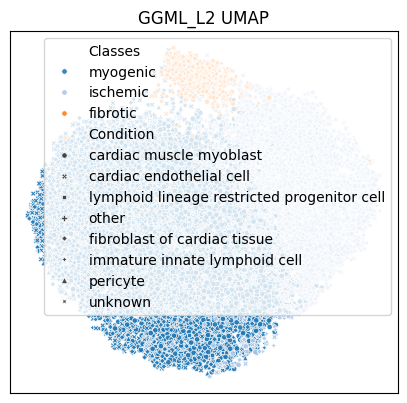

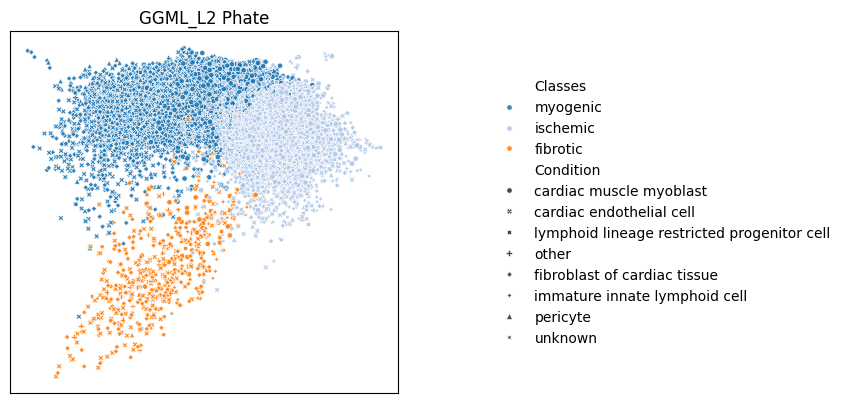

In [81]:
labels = np.asarray(datasets[dataset_name]["point_labels"])[selected_cells_ind]

theta = metric_params[dataset_name][metric_name]
theta2 = metric_params[dataset_name]["Euclidean"]

cell_dist1 = pairwise_mahalanobis_distance_npy(data_points,w = theta)
cell_dist2 = pairwise_mahalanobis_distance_npy(data_points,w = theta2)


cell_dist = (cell_dist1/np.average(cell_dist1) + cell_dist2/np.average(cell_dist2))/2


emb1 = plot_emb(cell_dist,method='umap',colors=labels,symbols=cell_types,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
emb2 = plot_emb(cell_dist,method='phate',colors=labels,symbols=cell_types,legend="Side",title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)



array([[ 0.00154573,  0.00605224],
       [-0.01091052, -0.00013804],
       [-0.02535889, -0.00301592],
       ...,
       [ 0.03176559, -0.00451492],
       [ 0.01804157, -0.00190512],
       [ 0.01329126, -0.00926006]])

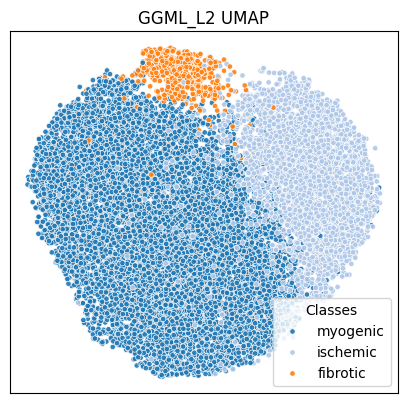

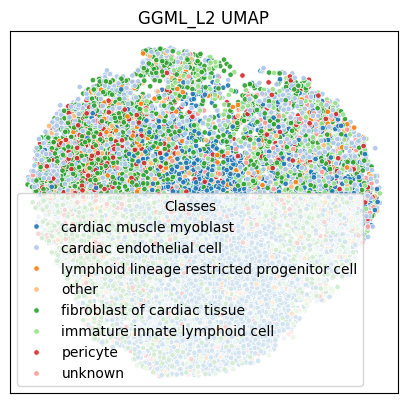

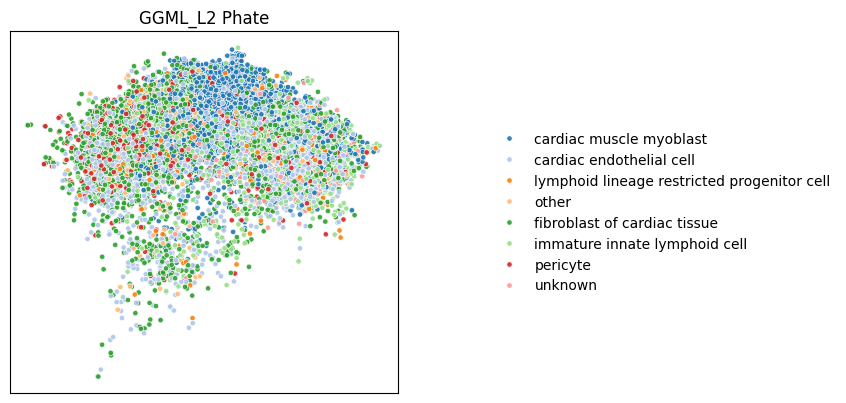

In [84]:

plot_emb(cell_dist1,precomputed_emb=emb1,method='umap',colors=labels,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
plot_emb(cell_dist1,precomputed_emb=emb1,method='umap',colors=cell_types,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=15)
plot_emb(cell_dist1,precomputed_emb=emb2,method='phate',colors=cell_types,legend="Side",title=f"{metric_name} Phate",verbose=True,annotation=None,s=15)

In [ ]:

from metric_learn import LMNN, LFDA, MLKR, NCA

W_star = np.asarray([[1,   0],
        [0,   0]])

#TODO load from file
W = np.asarray([[177.7152,   3.0272],
                [  0.2975, -0.05729]])
#W = np.asarray([[186.1389,   1.0033], [-50.9810,   2.1970]])

methods = {
    "groundtruth":lambda d: np.dot(W_star,d.transpose()).transpose(),
    "euclidean": lambda d: d,
    "ggml": lambda d: np.dot(W,d.transpose()).transpose(),
}

projection_plot(dists,labels,methods["ggml"],title="ggml")


In [ ]:
competing_methods = {    
    "nca": NCA(random_state=42,verbose=True),
    "lmnn":LMNN(n_neighbors=300, learn_rate=1e-6,verbose=True),
    "lfda": LFDA(k=300)}

for m in competing_methods:
    methods[m].fit(flat_dists,flat_labels)



Finding most discriminative components... 
done in  0.00s
[NCA]
[NCA]  Iteration      Objective Value    Time(s)
[NCA] ------------------------------------------
[NCA]          0         7.071879e+02       0.12
[NCA]          1         9.800936e+02       0.19
[NCA]          2         9.862309e+02       0.19
[NCA]          3         9.899162e+02       0.18
[NCA]          4         9.924528e+02       0.18
[NCA]          5         9.942496e+02       0.18
[NCA]          6         9.968222e+02       0.19
[NCA]          7         9.987592e+02       0.18
[NCA]          8         9.992175e+02       0.18
[NCA]          9         9.992304e+02       0.18
[NCA]         10         9.948872e+02       0.18
[NCA]         11         9.994384e+02       0.18
[NCA]         12         9.996642e+02       0.18
[NCA]         13         9.997439e+02       0.18
[NCA]         14         9.999767e+02       0.18
[NCA]         15         1.000062e+03       0.18
[NCA]         16         1.000856e+03       0.19
[NCA]

/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/metric_learn/lfda.py:109: UserWarning: Chosen k (300) too large, using 1 instead.
  warnings.warn('Chosen k (%d) too large, using %d instead.'
/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/metric_learn/lfda.py:163: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  return scipy.sparse.linalg.eigsh(a, k=dim, M=b, which='LA')


In [16]:

from sklearn.decomposition import PCA

def projection_plot(dists,labels,p,do_pca=True,title=""):
    i=0
    dfList_projected = []
    if do_pca:
        flat_dists = p(np.concatenate(dists))
        pca = PCA(n_components=1, svd_solver='full')
        pca.fit(flat_dists)

    for dist, l in zip(dists,labels):
        stacked_projected = p(dist) 
        if do_pca:
            stacked_projected = pca.transform(stacked_projected)
            stacked_projected = stacked_projected /np.max(np.abs(stacked_projected))
            dfList_projected.append(pd.DataFrame({'PCA_1':stacked_projected[:,0],'class':l,'dist':i % 4,'method':title})) #TODO ahrdcoded
        else:    
            dfList_projected.append(pd.DataFrame({'x':stacked_projected[:,0],'y':stacked_projected[:,1],'class':l,'dist':i % 4,'method':title})) #TODO ahrdcoded
        i += 1

    df_projected= pd.concat(dfList_projected, axis=0)
    plt.figure(figsize=(6,1))
    if do_pca:
        ax = sns.stripplot(df_projected, x="PCA_1",hue="class",alpha=0.5)
    else:
        ax = sns.scatterplot(df_projected,x='x',y='y',hue="class",style='dist',alpha=0.5)
    
    #ax.set_ylim(-0.01, 0.01)

    sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.5))
    ax.get_legend().remove()

    ax.set_title(title)

    return dfList_projected

dfs = {}

for m in methods:
    if m == "ggml" or m == "baseline" or m == "groundtruth":
        dfs[m]=projection_plot(dists,labels,methods[m],title=m)
    else:
    #try:
        dfs[m]=projection_plot(dists,labels,lambda d: methods[m].transform(d),title=m)
    #except:
    #    print(f"{m} failed")
dfs= pd.concat(sum(dfs.values(),[]), axis=(0))
plt.figure(figsize=(5,5))
ax = sns.stripplot(dfs, x="PCA_1", y="method",hue="class",alpha=0.5)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.5))
ax.set_title("Learned Transformation")

NameError: name 'methods' is not defined

In [ ]:
def plot_table(df,tranpose=False):
    format_df = df
    format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))
    

(1881, 1881)
0.04790866076943017
[2 1 1 ... 3 3 3]
(1881, 1881)
-0.0010565525524742735
[2 2 2 ... 3 3 3]
(1881, 1881)
0.007624735229367808
[1 1 1 ... 1 1 1]
(1881, 1881)
-0.0010565525524742735
[2 2 2 ... 3 3 3]


AttributeError: 'function' object has no attribute 'get_metric'

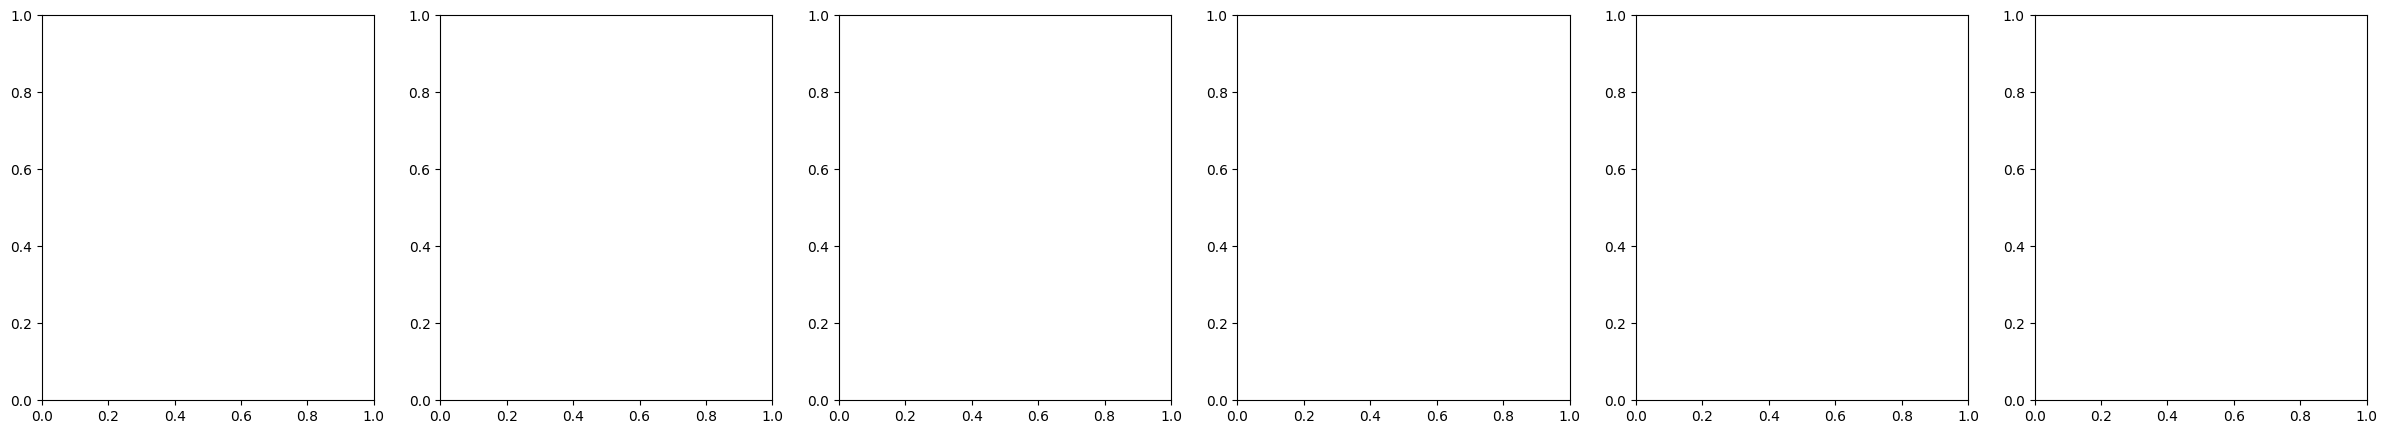

In [ ]:
import sklearn 
import scipy as sp
from ggml.benchmark import knn_from_dists

def compute_dist_matrix(X,d):
    D = np.zeros((len(X),len(X)))
    for i,x in enumerate(X):
        for j,y in enumerate(X):
            if i<=j:
                D[i,j] = d(x,y)
            else:
                D[i,j] = D[j,i]
    return D

results = {"method":[],
           #"KNN T=0.75":[],
           "KNN T=0.25":[],
           "ARI":[],
           #"VarInf":[],
           
           #"Time":[]}
}
fig, axs = plt.subplots(1,len(metrics.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)

for m, (method, trained_metric) in enumerate(methods.items()):
    if method=="ggml" or m == "baseline" or m == "groundtruth":
        #d = trained_metric
        if m == "baseline" or m == "groundtruth":
            continue
        theta = np.asarray([[-20.6616, 0],[0, 0.0407]])
        d= lambda x,y: np.linalg.norm(np.squeeze(np.dot(theta,x))-np.squeeze((np.dot(theta,y)))) 
    else:
        d = trained_metric.get_metric()

    D = compute_dist_matrix(flat_dists,d)

    print(D.shape)

    pred, true, score, _ = knn_from_dists(D,flat_labels,method=method,weights=None,test_size=0.5,n_splits=20,n_neighbors=30) #'distance'
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #pred2, true2, score2, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.9)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred2),np.concatenate(true2),title=f"{method} Distance KNN {len(pred2)}-Splits",ax=axs[1,m])

    #zero_dia_dists = precomputed_dists[method]
    #np.fill_diagonal(zero_dia_dists,0)
    #sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")

    #ari = adjusted_rand_score(np.concatenate(true),np.concatenate(pred))
    
    pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(flat_labels)),metric='precomputed',linkage='average').fit_predict(D)
    ari = sklearn.metrics.adjusted_rand_score(flat_labels,pred_cluster)
    print(ari)

    link = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(D), method='average', optimal_ordering=True)
    pred_cluster = sp.cluster.hierarchy.fcluster(link,t=len(np.unique(flat_labels)),criterion="maxclust")
    ari = sklearn.metrics.adjusted_rand_score(flat_labels,pred_cluster)
    print(pred_cluster)


    #_ , grouped_labels = np_unique_indices(labels) #[np.where([labels==l]) for l in np.unique(labels)]
    #_ , grouped_clust = np_unique_indices(pred_cluster) #[np.where([pred_cluster==l]) for l in np.unique(pred_cluster)]
    #print(grouped_labels)
    #print(grouped_clust)
    #truth = NodeClustering(grouped_labels, graph=None, method_name="Pathological labels")
    #pred = NodeClustering(grouped_clust, graph=None, method_name="Predicted Cluster")
    #eval = cdlib.evaluation.variation_of_information(truth,pred)

    #plt.show()
    results["method"].append(method)
    #results["Classification Score"].append(np.average(score))
    #results["KNN T=0.75"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    results["KNN T=0.25"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    results["ARI"].append(f"{np.average(ari):.2f}")
    #results["VarInf"].append(eval[0])
    #results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    #results["Time"].append(f"{times[method]/(len(ccb_emb[0])*(len(ccb_emb[0])-1)/2) * 1000: .2f}")

fig.tight_layout()
plot_table(pd.DataFrame(results))